# RGF with sparse matrices and periodicity

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import os
import math
import sys
import time
from scipy import sparse
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
from scipy.spatial import cKDTree
# from numba import jit
np.set_printoptions(linewidth = np.inf)
from scipy.spatial import distance_matrix
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
from scipy.spatial import cKDTree
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# np.set_printoptions(threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)


In [2]:
# Functions
# Function for calculating the positions of the atoms
def layer(four_atom_x, four_atom_y, shiftx, shifty, delx1, dely1, delx2, dely2, xcells1, ycells1, xcells2, ycells2, strainy1, strainy2, p, poisson):
    # L1
    layerx1, layery1 = np.array([]), np.array([])
    for i in np.arange(xcells1):
        for j in np.arange(ycells1):
            layerx1 = np.concatenate((layerx1, four_atom_x + i*shiftx))
            layery1 = np.concatenate((layery1, four_atom_y + j*shifty))
    layery1 = dely1 + layery1*(1 + strainy1)
    layerx1 = delx1 + layerx1*(1 - strainy1*poisson)
    layerz1 = np.transpose(np.ones(len(layerx1))*0)
    # L2
    layerx2, layery2 = np.array([]), np.array([])
    for i in np.arange(xcells2):
        for j in np.arange(ycells2):
            layerx2 = np.concatenate((layerx2, four_atom_x + i*shiftx))
            layery2 = np.concatenate((layery2, four_atom_y + j*shifty))
    layery2 = dely2 + layery2*(1 + strainy2)
    layerx2 = delx2 + layerx2*(1 - strainy2*poisson)
    layerz2 = np.transpose(np.ones(len(layerx2))*p)
    # Concatenate L1 & L2
    layerx = np.concatenate((layerx1, layerx2))
    layery = np.concatenate((layery1, layery2))
    layerz = np.concatenate((layerz1, layerz2))
    return layerx, layery, layerz

# Function for calculating the surface GFs from the leads (left and right)
# this version starts from the GF, not H, so works for more general lead cells
def surface_from_g(g00, V1, V2, epsilon):
    ii = np.identity(len(g00), dtype = 'complex128')
    g11old, gLLold, g1Lold, gL1old = g00, g00, g00, g00
    errL, errR = 1, 1
    while ((errL > epsilon) | (errR > epsilon)):
        t1 = np.dot(g11old, V2)
        t2 = np.dot(gLLold, V1)
        A = np.linalg.multi_dot([np.linalg.inv(ii - np.dot(t2, t1)), t2, g1Lold])
        B = np.linalg.multi_dot([np.linalg.inv(ii - np.dot(t1, t2)), t1, gL1old])
        gLLnew = gLLold + np.linalg.multi_dot([gL1old, V2, A])
        g11new = g11old + np.linalg.multi_dot([g1Lold, V1, B])
        g1Lnew = np.linalg.multi_dot([g1Lold, V1, g1Lold + np.dot(t1, A)])
        gL1new = np.linalg.multi_dot([gL1old, V2, gL1old + np.dot(t2, B)])
        # Biggest error on either side
        errL = np.abs((g11new - g11old)).flatten().max()
        errR = np.abs((gLLnew - gLLold)).flatten().max()
        # Update GFs
        g11old, gLLold, gL1old, g1Lold = g11new, gLLnew, gL1new, g1Lnew
    return gLLold, g11old

# Function for splitting the lattice
# (possibly move the tree ball bit outside as it may be useful elsewhere?)
def SplitLattice(coords, starting_set, dist, shiftyy):
    cells_other = []
    coords_t, coords_b = np.copy(coords), np.copy(coords)
    coords_t[:, 1] += shiftyy
    coords_b[:, 1] -= shiftyy
    num_atoms = len(coords)
    coords_else = np.vstack([coords, coords_t, coords_b])
    tree = cKDTree(coords_else)
    neighbours = tree.query_ball_tree(tree, dist) 
    neighbours = neighbours[:num_atoms]
    new_neighbours = []
    for temp in neighbours:
        temp2 = list(np.unique(np.mod(np.array(temp), num_atoms)))
        new_neighbours.append(temp2)
    neighbours = new_neighbours    
    unassigned = list(np.arange(len(coords)))
    cells_other = [starting_set]
    while len(unassigned) > 0:
        unassigned = list(set(unassigned) - set(cells_other[-1]))
        temp = [i for j in cells_other[-1] for i in neighbours[j]]
        new = list(set(unassigned) & set(temp)) 
        if (len(new) > 0):
            cells_other.append(new) 
    cells_other = cells_other[::-1]
    return cells_other

# Function for calculating Hamiltonian for TB Method
# calculates only specific matrix elements
# useful for creating sparse matrices
def t_general_list(coordsxy, coordz, pairs, vp0, vs0, cutoff):
    dxy = np.sqrt((coordsxy[pairs[:, 0], 0] - coordsxy[pairs[:, 1], 0])**2 + (coordsxy[pairs[:, 0], 1] - coordsxy[pairs[:, 1], 1])**2)
    dz = coordz[pairs[:, 0]] - coordz[pairs[:, 1]]
    r = np.sqrt(dxy**2 + dz**2)
    hop = np.zeros(len(pairs), dtype = 'complex128')
    r0 = 0.184*2.46
    vp = vp0*np.exp(-(r-1.42)/r0)
    vs = vs0*np.exp(-(r-3.35)/r0)
    hop = vp*(1-(dz/r)**2) + vs*(dz/r)**2
    return hop

# This version works if there are two different systems
def t_general_list2(coordsxy, coordsxy2, coordz, coordz2, pairs, vp0, vs0, cutoff):
    dxy = np.sqrt( (coordsxy[pairs[:, 0], 0] - coordsxy2[pairs[:, 1], 0])**2 + (coordsxy[pairs[:, 0], 1] - coordsxy2[pairs[:, 1], 1])**2)
    dz = coordz[pairs[:, 0]] - coordz2[pairs[:, 1]]
    r = np.sqrt(dxy**2 + dz**2)
    hop = np.zeros(len(pairs), dtype = 'complex128')
    r0 = 0.184*2.46
    vp = vp0*np.exp(-(r-1.42)/r0)
    vs = vs0*np.exp(-(r-3.35)/r0)
    hop = vp*(1-(dz/r)**2) + vs*(dz/r)**2
    return hop

# usual t-general
def t_general_vec(xyc, zc, vp0, vs0, cutoff):
    r1 = distance_matrix(xyc, xyc)
    dz = zc - zc[:, np.newaxis]
    r = np.sqrt(r1**2 + dz**2)
    hop = np.zeros_like(r)
    r0 = 0.184*2.46
    vp = vp0*np.exp(-(r-1.42)/r0)
    vs = vs0*np.exp(-(r-3.35)/r0)
    indices = (r1 <= cutoff) & (r !=0)
    hop[indices] = vp[indices]*(1-(dz[indices]/r[indices])**2) + vs[indices]*(dz[indices]/r[indices])**2
    return hop

# this version for multiple cells
def t_general_vec2(xyc, xyc2, zc, zc2, vp0, vs0, cutoff):
    r1 = distance_matrix(xyc, xyc2)
    dz = zc2 - zc[:,np.newaxis]
    r = np.sqrt(r1**2 + dz**2)
    hop = np.zeros_like(r)
    r0 = 0.184*2.46
    vp = vp0*np.exp(-(r-1.42)/r0)
    vs = vs0*np.exp(-(r-3.35)/r0)
    indices = (r1 <= cutoff) & (r != 0)
    hop[indices] = vp[indices]*(1-(dz[indices]/r[indices])**2) + vs[indices]*(dz[indices]/r[indices])**2
    return hop

# functions to get the corresponding hamiltonian indices using KDtrees
def get_full_pairs(tree, dist):
    pairs = list(tree.query_pairs(dist)) 
    all_pairs = []
    for pair in pairs:
        all_pairs.append(pair[::-1])
    all_pairs = np.array(pairs + all_pairs)
    return all_pairs

def get_full_pairs2(tree, tree2, dist):
    data = list(tree.query_ball_tree(tree2, dist)) 
    # convert to lists of pairs
    pairs = [(row_idx, item) for row_idx, row in enumerate(data) for item in row]
    if len(pairs) == 0:
        pairs = np.empty([0,2])
    return np.array(pairs)

# Function for splitting the lattice
# new version that uses the neighbour lists we have already calculated
def SplitLattice_new(coords, starting_set, dpairs, mpairs, ppairs):
    unassigned = list(np.arange(len(coords)))                 
    cells_other = [list(starting_set)]
    while len(unassigned) > 0:
        unassigned = list(set(unassigned) - set(cells_other[-1]))
        temp = np.unique(np.concatenate([dpairs[np.where(np.in1d(dpairs[:,0], cells_other[-1])), 1][0] , 
                                mpairs[np.where(np.in1d(mpairs[:,0], cells_other[-1])), 1][0],
                                ppairs[np.where(np.in1d(ppairs[:,0], cells_other[-1])), 1][0]]))
        new = list(set(unassigned) & set(temp)) 
        if (len(new) > 0):
            cells_other.append(new)
    cells_other = cells_other[::-1]
    return cells_other

def dos_transmission(eta, energy, cells, potentials, epsilon, ky, shiftyy, hdev_, hdev_my_, hdev_py_,VLR_lead, VLR_lead_m, VLR_lead_p, llead_ind, rlead_ind, ydim, sys_size):
    temp, temp_trans, total_dos = 0, 0, 0
    # Loop over k points
    for jj, (k2) in enumerate(ky):
        # Cell 0
        ind = cells[0]
        # N.N.B note how to PROPERLY get a dense block of a sparse matrix
        # Take the sublock of the sparse matrix first, and THEN convert to dense/array!
        H0_small = hdev_[np.ix_(ind, ind)].todense()
        H0_small_my = hdev_my_[np.ix_(ind, ind)].todense()
        H0_small_py = hdev_py_[np.ix_(ind, ind)].todense()
        H0_small_ = H0_small + H0_small_my*np.exp(-1j*k2*shiftyy) + H0_small_py*np.exp(1j*k2*shiftyy) + np.diag(potentials[ind])
        ii = np.identity(len(H0_small_), dtype = 'complex128')
        g_old = np.linalg.inv(np.dot(ii, e333[tt] + eta*1j) - H0_small_)
        total_dos -= 1/np.pi*np.imag(np.trace(g_old))
        # Build device GF recursively (Loop over cells) (WITHOUT ADDING LEADS)
        for i in range(1, len(cells)):
            # indices
            ind = cells[i]
            ind_m = cells[i - 1]
            # cell H and g
            H0_small = hdev_[np.ix_(ind, ind)].todense()
            H0_small_my = hdev_my_[np.ix_(ind, ind)].todense()
            H0_small_py = hdev_py_[np.ix_(ind, ind)].todense()
            H0_small_ = H0_small + H0_small_my*np.exp(-1j*k2*shiftyy) + H0_small_py*np.exp(1j*k2*shiftyy) + np.diag(potentials[ind])
            ii = np.identity(len(H0_small_), dtype = 'complex128')
            g_ii = np.linalg.inv(np.dot(ii, e333[tt] + eta*1j) - H0_small_)
            # connection matrices (use transposes for vrl)
            # lr means i-1 to i, not necessarily left-to-right
            VLR = hdev_[np.ix_(ind_m, ind)].todense()
            VLR_my = hdev_my_[np.ix_(ind_m, ind)].todense()
            VLR_py = hdev_py_[np.ix_(ind_m, ind)].todense()
            vlr_ = VLR + VLR_my*np.exp(-1j*k2*shiftyy) + VLR_py*np.exp(1j*k2*shiftyy)
            G_ii = np.dot(np.linalg.inv(ii - np.linalg.multi_dot([g_ii, np.conj(vlr_.T), g_old, vlr_])), g_ii)
            if i == 1:
                An = np.dot(np.conj(vlr_.T), np.dot(g_old, np.dot(g_old, vlr_)))
                total_dos -= 1/np.pi*np.imag(np.trace(np.dot(G_ii, An + np.eye(len(An)))))
                g_old = G_ii
            elif (1 < i < len(cells)-1):
                An = np.dot(np.conj(vlr_.T), np.dot(g_old, np.dot(An + np.eye(len(An)), np.dot(g_old, vlr_))))
                total_dos -= 1/np.pi*np.imag(np.trace(np.dot(G_ii, An + np.eye(len(An)))))
                g_old = G_ii
        # Use Rubio-Sancho method to find lead surface GFs
        vlr_r = VLR_lead + VLR_lead_m*np.exp(-1j*k2*shiftyy) + VLR_lead_p*np.exp(1j*k2*shiftyy)
        G_left_full, G_right_full = surface_from_g(G_ii, vlr_r, np.conj(vlr_r.T), epsilon)
        SL = G_left_full[np.ix_(rlead_ind, rlead_ind)]
        SR = G_right_full[np.ix_(llead_ind, llead_ind)]
        # device to lead matrices
        VDL = hdev2l + hdev2l_my*np.exp(-1j*k2*shiftyy) + hdev2l_py*np.exp(1j*k2*shiftyy)
        VDR = hdev2r + hdev2r_my*np.exp(-1j*k2*shiftyy) + hdev2r_py*np.exp(1j*k2*shiftyy)
        # self-energies for each lead
        self_l = np.linalg.multi_dot([VDL, SL,  np.conj(VDL.T)])
        self_r = np.linalg.multi_dot([VDR, SR,  np.conj(VDR.T)])
        # gammas from each lead        
        Gamma_L = 1j*(self_l - np.conj(self_l.T))
        Gamma_R = 1j*(self_r - np.conj(self_r.T)) 
        # add self energies using dyson
        full_self = np.zeros_like(G_ii)
        full_self[np.ix_(llead_ind, llead_ind)] = self_l
        full_self[np.ix_(rlead_ind, rlead_ind)] = self_r
        ii = np.identity(len(G_ii), dtype = 'complex128')
        full_g =  np.linalg.inv(ii - np.dot(G_ii, full_self)).dot(G_ii)
        GLR = full_g[np.ix_(llead_ind, rlead_ind)]
        temp_trans += np.trace(np.linalg.multi_dot([np.conj(GLR.T), Gamma_L, GLR, Gamma_R]))
        An = np.dot(np.conj(vlr_.T), np.dot(g_old, np.dot(An + np.eye(len(An)), np.dot(g_old, vlr_))))
        total_dos -= 1/np.pi*np.imag(np.trace(np.dot(full_g,  An + np.eye(len(An)))))
        if jj == len(ky) - 1:
            temp_trans = temp_trans/(ydim*len(ky))
            total_dos = total_dos/(sys_size*len(ky))
    return temp_trans, total_dos


In [3]:
# General parameters
alat = 2.46 # Used when drawing bands
thop = -2.7 # In-plane hopping term
sigma = 0.48 # For hopping terms
d = 3.35 # Interlayer distance
acc = 1/np.sqrt(3) # Carbon-carbon (e.g. nearest neighbour) distance
dd = acc*alat + 0.4
eta = 0.001 # Parameter for DOS calculation, delta function
epsilon = 0.00000001
delta = 0.8 # Determines interlayer bias
en = 100 # Points in energy space
ene = 0.1 # Range in energy space
e333 = np.linspace(-ene, ene, en).tolist() # Define the energy range
poisson = 0.4 # Poisson ratio
strainy1 = 0.01 # Strain on the bottom layer along x and y direction
strainy2 = 0 # Strain on the top layer along x and y direction
shiftx, shifty = alat, 3*acc*alat
four_atom_x = np.array([0, -0.5, -0.5, 0])*alat
four_atom_y = np.array([0, 0.5*acc, 1.5*acc, 2*acc])*alat
xdim1, ydim1 = 250, 100 # Number of cells along x and y direction for L1
xdim2, ydim2 = 249, 101 # Number of cells along x and y direction for L2
shiftxx, shiftyy = xdim1*shiftx*(1-poisson*strainy1), ydim1*shifty*(1+strainy1)
ky = np.linspace(0, np.pi/shiftyy, 7)
delx1, dely1, delx2, dely2 = 0, 0, 0, 0 # AA stacking

# For the central device
# Coords
layerx, layery, layerz = layer(four_atom_x, four_atom_y, shiftx, shifty, delx1, dely1, delx2, dely2, xdim1, ydim1, xdim2, ydim2, strainy1, strainy2, d, poisson)
coords_dev = np.array((layerx, layery)).T
sys_size = len(coords_dev)
# connectivity
dtree = cKDTree(coords_dev)
dpairs = get_full_pairs(dtree, dd)
# image of device in -y direction
mtree = cKDTree(np.array((layerx, layery - shiftyy)).T)
mpairs = get_full_pairs2(dtree, mtree, dd)
# image of device in +y direction
ptree = cKDTree(np.array((layerx, layery + shiftyy)).T)
ppairs = get_full_pairs2(dtree, ptree, dd)

# Atoms on the bottom layer
L1 = np.where(layerz == 0.0)
# # Plot
# plt.figure(figsize = (8,16))
# plt.plot(layerx, layery, 'ko', alpha = 0.3)
# plt.plot(layerx, layery - shiftyy, 'ro', alpha = 0.3)
# plt.plot(layerx, layery + shiftyy, 'bo', alpha = 0.3)
# plt.ylim(layery.min() - 3, layery.max() + 3)
# plt.xlim(layerx.min() - 1, layerx.max() + 1)
# plt.gca().set_aspect('equal')

# Hamiltonian generation: (device in sparse format)
# within cell, to cell below, to cell above
# NB!
# need the .todok() bit so that you can use slicing to return ONLY THE NECESSARY ELEMENTS 
# of the sparse matrix when taking subblocks!!!!!
Hdev = t_general_list(coords_dev, layerz, dpairs, thop, sigma, dd)
hdev_ = sparse.coo_matrix((Hdev, (dpairs[:, 0], dpairs[:, 1])), 
                           shape = (len(layerx), len(layery))).todok()

# Add interlayer bias
potentials = np.zeros(sys_size, dtype=float)
potentials[: len(L1[0])] = delta/2
potentials[ len(L1[0]) : ] = -delta/2

Hdev_my = t_general_list2(coords_dev, 
                        np.array((layerx, layery - shiftyy)).T, 
                         layerz, 
                         layerz, 
                         mpairs, 
                         thop, sigma, dd)
hdev_my_ = sparse.coo_matrix((Hdev_my, (mpairs[:, 0], mpairs[:, 1])), 
                           shape = (len(layerx), len(layery))).todok()

Hdev_py = t_general_list2(coords_dev, 
                        np.array((layerx, layery + shiftyy)).T, 
                         layerz, 
                         layerz, 
                         ppairs, 
                         thop, sigma, dd)
hdev_py_ = sparse.coo_matrix((Hdev_py, (ppairs[:, 0], ppairs[:, 1])), 
                           shape = (len(layerx), len(layery))).todok()

# important site indices and connectivities
# DEVICE_TO_LEAD
ltree = cKDTree(np.array((layerx - shiftxx, layery)).T)
ltree_m = cKDTree(np.array((layerx - shiftxx, layery - shiftyy)).T)
ltree_p = cKDTree(np.array((layerx - shiftxx, layery + shiftyy)).T)

rtree = cKDTree(np.array((layerx + shiftxx, layery)).T)
rtree_m = cKDTree(np.array((layerx + shiftxx, layery - shiftyy)).T)
rtree_p = cKDTree(np.array((layerx + shiftxx, layery + shiftyy)).T)

dev_l_pairs = get_full_pairs2(dtree, ltree, dd)
dev_lm_pairs = get_full_pairs2(dtree, ltree_m, dd)
dev_lp_pairs = get_full_pairs2(dtree, ltree_p, dd)

dev_r_pairs = get_full_pairs2(dtree, rtree, dd)
dev_rm_pairs = get_full_pairs2(dtree, rtree_m, dd)
dev_rp_pairs = get_full_pairs2(dtree, rtree_p, dd)

# lists of sites in device which the left and right leads connects to
dev_sites_l = np.unique(np.concatenate([dev_l_pairs[:,0], dev_lm_pairs[:,0], dev_lp_pairs[:,0]])).astype(int)
dev_sites_r = np.unique(np.concatenate([dev_r_pairs[:,0], dev_rm_pairs[:,0], dev_rp_pairs[:,0]])).astype(int)
starting_cell = np.concatenate([dev_sites_l, dev_sites_r])

# lists of sites in leads which connect to the device
llead_sites = np.unique(np.concatenate([dev_l_pairs[:,1], dev_lm_pairs[:,1], dev_lp_pairs[:,1]])).astype(int)
rlead_sites = np.unique(np.concatenate([dev_r_pairs[:,1], dev_rm_pairs[:,1], dev_rp_pairs[:,1]])).astype(int)

# device site indices relative to last cell only (used in transport calculation)
llead_ind = np.arange(len(rlead_sites))
rlead_ind = np.arange(len(llead_sites)) + len(rlead_sites)

# these are the only sites needed in the lead cell
# can be used to make a reduced GF matrix 
# (only applies for big lead cells, as in Moire systems)
red_lead_sites = np.concatenate([rlead_sites, llead_sites])

# # Plot
# plt.figure(figsize = (8,20))
# plt.plot(layerx, layery, 'ko')
# plt.plot(layerx, layery - shiftyy, 'ko', alpha = 0.3)
# plt.plot(layerx, layery + shiftyy, 'ko', alpha = 0.3)
# plt.plot(layerx - shiftxx, layery, 'ro')
# plt.plot(layerx - shiftxx, layery - shiftyy, 'ro', alpha = 0.3)
# plt.plot(layerx - shiftxx, layery + shiftyy, 'ro', alpha = 0.3)
# plt.plot(layerx + shiftxx, layery, 'bo')
# plt.plot(layerx + shiftxx, layery - shiftyy, 'bo', alpha = 0.3)
# plt.plot(layerx + shiftxx, layery + shiftyy, 'bo', alpha = 0.3)
# [plt.plot([layerx[i], (layerx - shiftxx)[j]], [layery[i], layery[j]], 'r-', alpha = 0.4) for i, j in dev_l_pairs]
# [plt.plot([layerx[i], (layerx - shiftxx)[j]], [layery[i], (layery - shiftyy)[j]], 'g-', alpha = 0.4) for i, j in dev_lm_pairs]
# [plt.plot([layerx[i], (layerx - shiftxx)[j]], [layery[i], (layery + shiftyy)[j]], 'g-', alpha = 0.4) for i, j in dev_lp_pairs]
# [plt.plot([layerx[i], (layerx + shiftxx)[j]], [layery[i], layery[j]], 'b-', alpha = 0.4) for i, j in dev_r_pairs]
# [plt.plot([layerx[i], (layerx + shiftxx)[j]], [layery[i], (layery - shiftyy)[j]], 'g-', alpha = 0.4) for i, j in dev_rm_pairs]
# [plt.plot([layerx[i], (layerx + shiftxx)[j]], [layery[i], (layery + shiftyy)[j]], 'g-', alpha = 0.4) for i, j in dev_rp_pairs]
# plt.gca().set_aspect('equal')
# plt.plot()

VLR_lead =  t_general_vec2(coords_dev[red_lead_sites], 
                         np.array((layerx + shiftxx, layery)).T[red_lead_sites],
                        layerz[red_lead_sites], 
                      layerz[red_lead_sites], 
                       thop, sigma, dd)
VLR_lead_m = t_general_vec2(coords_dev[red_lead_sites], 
                         np.array((layerx + shiftxx, layery-shiftyy)).T[red_lead_sites],
                        layerz[red_lead_sites], 
                       layerz[red_lead_sites], 
                       thop, sigma, dd)
VLR_lead_p = t_general_vec2(coords_dev[red_lead_sites], 
                         np.array((layerx + shiftxx, layery+shiftyy)).T[red_lead_sites],
                        layerz[red_lead_sites], 
                       layerz[red_lead_sites], 
                       thop, sigma, dd)

hdev2l = t_general_vec2(coords_dev[dev_sites_l], 
                         np.array((layerx - shiftxx, layery)).T[llead_sites],
                        layerz[dev_sites_l], 
                       layerz[llead_sites], 
                       thop, sigma, dd)
hdev2l_my = t_general_vec2(coords_dev[dev_sites_l], 
                         np.array((layerx - shiftxx, layery-shiftyy)).T[llead_sites],
                        layerz[dev_sites_l], 
                       layerz[llead_sites], 
                       thop, sigma, dd)
hdev2l_py = t_general_vec2(coords_dev[dev_sites_l], 
                         np.array((layerx - shiftxx, layery+shiftyy)).T[llead_sites],
                        layerz[dev_sites_l], 
                       layerz[llead_sites], 
                       thop, sigma, dd)
hdev2r = t_general_vec2(coords_dev[dev_sites_r], 
                         np.array((layerx + shiftxx, layery)).T[rlead_sites],
                        layerz[dev_sites_r], 
                       layerz[rlead_sites], 
                       thop, sigma, dd)
hdev2r_my = t_general_vec2(coords_dev[dev_sites_r], 
                         np.array((layerx + shiftxx, layery-shiftyy)).T[rlead_sites],
                        layerz[dev_sites_r], 
                       layerz[rlead_sites], 
                       thop, sigma, dd)
hdev2r_py = t_general_vec2(coords_dev[dev_sites_r], 
                         np.array((layerx + shiftxx, layery+shiftyy)).T[rlead_sites],
                        layerz[dev_sites_r], 
                       layerz[rlead_sites], 
                       thop, sigma, dd)

cells = SplitLattice_new(coords_dev, starting_cell, dpairs, mpairs, ppairs)


In [32]:
# Calculate the transmission & the DOS(E) with a function (1% heterostrain), 400 meV bias
start = time.time()
transmission, tdos = [], []
for tt in range(len(e333)):
    temp_trans, total_dos = dos_transmission(eta, e333[tt], cells, potentials, epsilon, ky, shiftyy, hdev_, hdev_my_, hdev_py_,VLR_lead, VLR_lead_m, VLR_lead_p, llead_ind, rlead_ind, ydim2, sys_size)
    transmission.append(temp_trans)
    tdos.append(total_dos)
np.save('transmission_1strain_400bias_7ky_100energy_01.npy', transmission)
np.save('tdos_1strain_400bias_7ky_100energy_01.npy', tdos)
np.save('e333.npy', e333)
end = time.time()
print('time', (end - start)/60)


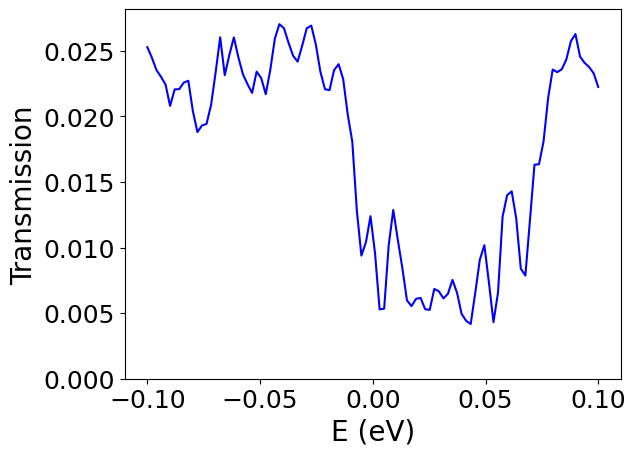

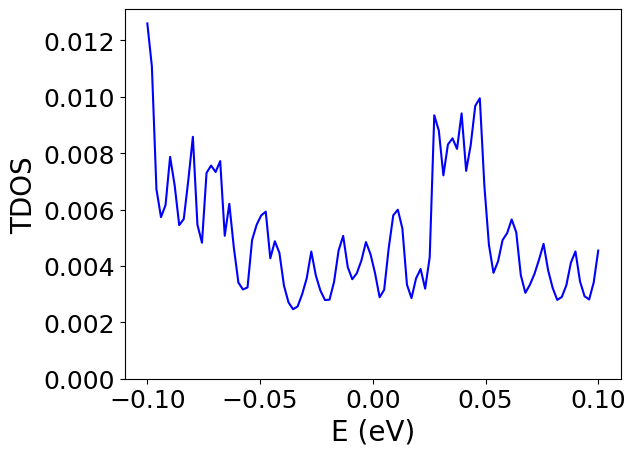

In [34]:
# Plots
en = 100 # Points in energy space
ene = 0.1 # Range in energy space
e333 = np.linspace(-ene, ene, en).tolist() # Define the energy range
matplotlib.rcParams.update({'font.size': 18})
# Transmission
transmission = np.load('transmission_1strain_800bias_7ky_100energy_01.npy')
plt.plot(e333, np.real(transmission), c = 'b')
plt.xlabel('E (eV)', fontsize = 20)
plt.ylabel('Transmission', fontsize = 20)
plt.ylim(0, )
plt.show()
# TDOS
tdos = np.load('tdos_1strain_800bias_7ky_100energy_01.npy')
# x = 0.0393939*np.ones(100)
# y = np.linspace(0, 0.012, 100)
# plt.plot(x, y, c = 'k')
plt.plot(e333, np.array(tdos), c = 'b')
plt.xlabel('E (eV)', fontsize = 20)
plt.ylabel('TDOS', fontsize = 20)
plt.ylim(0, )
plt.show()


In [8]:
print(transmission[50:99])

[0.0095493 -3.06704999e-20j 0.00528573-3.63445424e-20j 0.00534043+7.36091998e-20j 0.01020014+1.81569360e-19j 0.01286443-7.26277438e-19j 0.01057832+2.68366874e-19j 0.00842425-3.58231439e-19j 0.00597648+9.19348235e-20j 0.00553373-1.27282575e-20j 0.0060903 +1.71754800e-20j 0.00615776+1.71754800e-20j 0.00529922-3.76480387e-20j 0.0052451 +3.25107299e-20j 0.00684062-4.90727999e-19j 0.00667031+3.40442549e-19j 0.0061229 -8.81853549e-19j 0.00647251-4.18253608e-18j 0.00753286-1.49672040e-18j 0.00654734+2.88670745e-18j 0.00494072+1.36384046e-18j 0.00441435-2.11013040e-19j 0.00417058+8.10928018e-19j 0.00654748-4.48034663e-18j 0.00907135+8.02340278e-19j 0.0101824 -3.49643699e-19j 0.00733079+3.22653659e-19j 0.004312  -1.45684875e-20j 0.00657367+5.58203099e-20j 0.01235867-7.87925143e-19j 0.01399052+8.26876678e-19j 0.01428277+4.78459799e-20j 0.01220459-1.77275490e-19j 0.0083961 -9.81455998e-20j 0.00786058+7.75196886e-20j 0.01205148-4.44722249e-20j 0.01630858-3.89515349e-20j 0.01635269-4.04850599e-20j 

In [30]:
print(e333[65:100])

[0.03131313131313132, 0.033333333333333326, 0.03535353535353536, 0.037373737373737365, 0.0393939393939394, 0.0414141414141414, 0.043434343434343436, 0.04545454545454544, 0.047474747474747475, 0.04949494949494948, 0.051515151515151514, 0.05353535353535352, 0.05555555555555555, 0.05757575757575756, 0.05959595959595959, 0.0616161616161616, 0.06363636363636363, 0.06565656565656566, 0.06767676767676767, 0.0696969696969697, 0.07171717171717171, 0.07373737373737374, 0.07575757575757575, 0.07777777777777778, 0.07979797979797978, 0.08181818181818182, 0.08383838383838382, 0.08585858585858586, 0.08787878787878786, 0.0898989898989899, 0.0919191919191919, 0.09393939393939393, 0.09595959595959597, 0.09797979797979797, 0.1]
